In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn import svm

In [2]:
param_data = pd.read_csv("../data/interim/interim_data.csv")
param_data.head()

,ID,StudySample,LaserPowerHatch,LaserSpeedHatch,HatchSpacing,LaserPowerContour,Porosity,LayerHeight,EnergyDensityCalculated,Machine,Powder,MicroCTScan,HatchOffsetFromCountour
0,1,Plessis_1-1,280.0,1200.0,0.14,150.0,0.013,0.03,55.555556,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
1,2,Plessis_1-2,252.0,1200.0,0.14,135.0,0.008,0.03,50.000000,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
2,3,Plessis_1-3,224.0,1200.0,0.14,120.0,0.007,0.03,44.444444,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
3,4,Plessis_1-4,197.0,1200.0,0.14,105.0,0.045,0.03,39.087302,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
4,5,Plessis_1-5,308.0,1200.0,0.14,165.0,0.017,0.03,61.111111,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015


In [12]:
features = ["LaserPowerHatch","LaserSpeedHatch","Porosity"]
for col in param_data.columns:
    try:
        # dropping unnecessary columns, put into error catching so the program doesn't quit if one of these are already dropped or doesnt exist
        if col not in features:
            param_data = param_data.drop(col, axis=1)
            print(f"dropped {col}")
    except:
        print(f"already dropped {col}")
try:
    # dropping outliers
    param_data = param_data.drop([10,14,9], axis=0).reset_index(drop=True)
except:
    print('already dropped outliers')
# reorder to put label (Porosity) to make label selection easy (can index last column with [:,-1])
param_data = param_data[features]

In [13]:
# test train split, random sampling, train/test exports - can be left alone
tt_split = .25
pct = 1 - tt_split
seed = 200

train_data = param_data.sample(frac=pct, random_state=seed).reset_index(drop=True)
test_data = param_data.drop(train_data.index).sample(frac=1, random_state=seed).reset_index(drop=True)

In [21]:
def feature_label_join(X, y):
    df = pd.DataFrame(np.concatenate([X,y], axis=1))
    return df

def transform(train_data, test_data, scale_X, scale_y):
    train_vals = train_data.values
    test_vals = test_data.values

    X_train = scale_X.fit_transform(train_vals[:,:-1])
    y_train = scale_y.fit_transform(train_vals[:,-1].reshape(-1, 1))

    X_test = scale_X.transform(test_vals[:,:-1])
    y_test = scale_y.transform(test_vals[:,-1].reshape(-1, 1))

    train = feature_label_join(X_train, y_train)
    test = feature_label_join(X_test, y_test)

    return train, test

train, test = transform(train_data, test_data, MinMaxScaler(), StandardScaler())

In [31]:
#svr = svm.SVR(kernel='poly', degree=2)
#svr.fit(train.values[:,:-1], train.values[:,-1])

scorer = make_scorer(mean_squared_error, greater_is_better=False)
params = [{'kernel': ['poly'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 10, 100, 1000, 10000]}]
svr_gs = GridSearchCV(svm.SVR(epsilon = 0.01), params, cv = 5, scoring=scorer)
svr_gs.fit(train.values[:,:-1], train.values[:,-1])
#print('svr score:', svr.score(test.values[:,:-1], test.values[:,-1]))
print(svr_gs.score(test.values[:,:-1], test.values[:,-1]))
means = svr_gs.cv_results_['mean_test_score']
stds = svr_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

-0.21510439147651272
-1.179 (+/-3.523) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
-1.179 (+/-3.523) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
-1.179 (+/-3.523) for {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
-1.177 (+/-3.519) for {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
-1.165 (+/-3.492) for {'C': 1, 'gamma': 0.2, 'kernel': 'poly'}
-0.984 (+/-3.065) for {'C': 1, 'gamma': 0.5, 'kernel': 'poly'}
-0.870 (+/-2.776) for {'C': 1, 'gamma': 0.6, 'kernel': 'poly'}
-0.394 (+/-1.367) for {'C': 1, 'gamma': 0.9, 'kernel': 'poly'}
-1.179 (+/-3.523) for {'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}
-1.179 (+/-3.523) for {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}
-1.179 (+/-3.523) for {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}
-1.162 (+/-3.484) for {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}
-1.049 (+/-3.217) for {'C': 10, 'gamma': 0.2, 'kernel': 'poly'}
-0.166 (+/-0.585) for {'C': 10, 'gamma': 0.5, 'kernel': 'poly'}
-0.183 (+/-0.529) for {'C': 10, 'gamma': 0.6, 'kernel': 'poly'}
-0.258 (+/-0.64

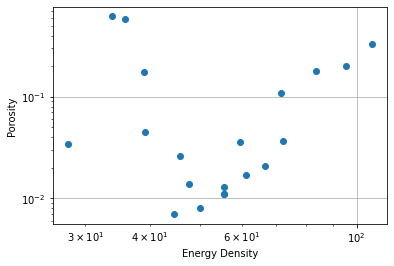

In [145]:
plt.loglog(param_data.EnergyDensityCalculated, param_data.Porosity, 'o')
plt.grid()
plt.ylabel('Porosity')
plt.xlabel('Energy Density')
plt.show()

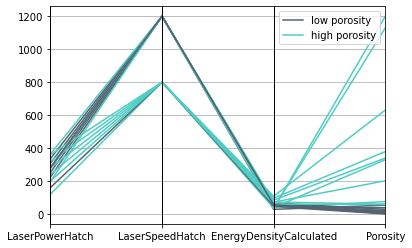

In [146]:
scale_porosity = MinMaxScaler(feature_range=(0,1200))
param_data.Porosity = scale_porosity.fit_transform(param_data.Porosity.values.reshape(-1,1))
cols = ['LaserPowerHatch', 'LaserSpeedHatch', 'EnergyDensityCalculated', 'Porosity']
param_data['level']  = pd.qcut(param_data.Porosity, q=[0, 0.5, 1.0], labels =['low porosity','high porosity'])
pd.plotting.parallel_coordinates(param_data, class_column='level', cols=cols, color=('#556270', '#4ECDC4', '#C7F464'))
plt.show()

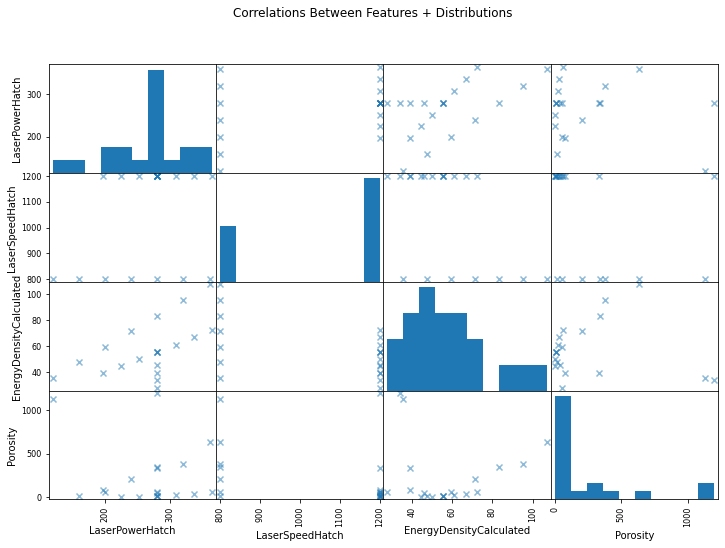

In [147]:
pd.plotting.scatter_matrix(param_data[cols], marker='x',figsize=(12,8))
plt.suptitle('Correlations Between Features + Distributions')
plt.show()